<a href="https://colab.research.google.com/github/JAEHYEONG8121/Pytorch-Tutorial/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GoogLeNet

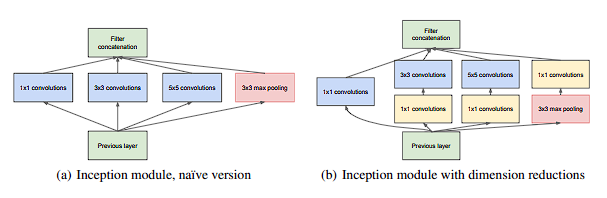

- The core idea of Inception module is to use filters of different sizes in parallel to extract features at various scales.
- Inception module naive form, 5x5 conv can be very expensive.
- So,rather than doing 5x5 conv on the previous layer all of those filters, doing 1x1 conv before the 3x3 and 5x5 conv.
- The only thing that 1x1 convolution is gonna do is it's gonna reduce the number of filters.

***

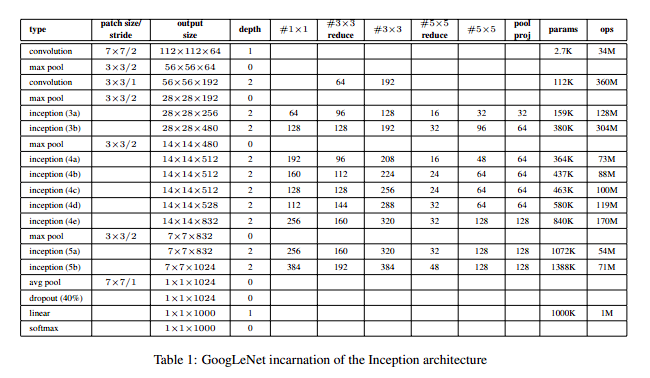

- This is an architecture of GoogLeNet.
- We should focus on the inception blocks.
- 3x3 reduce and 5x5 reduce mean that dimension reduce by using 1x1 filter before the 3x3 conv and 5x5 conv.


In [2]:
# Imports
import torch
import torch.nn as nn

In [9]:
class GoogLeNet(nn.Module):
  def __init__(self, in_channels=3, num_classes=1000):
    super(GoogLeNet, self).__init__()

    self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size=(7, 7),
                            stride=(2, 2), padding=(3, 3))
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, 1000)

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)

    x = self.inception4a(x)
    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    x = self.inception4e(x)
    x = self.maxpool4(x)

    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)
    return x

In [4]:
class Inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(Inception_block, self).__init__()

    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

    self.branch2 = nn.Sequential(
        conv_block(in_channels, red_3x3, kernel_size=1), # stride=1, padding=0 is default
        conv_block(red_3x3, out_3x3, kernel_size=3, stride=1, padding=1)
    )

    self.branch3 = nn.Sequential(
        conv_block(in_channels, red_5x5, kernel_size=1),
        conv_block(red_5x5, out_5x5, kernel_size=5, stride=1, padding=2)
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        conv_block(in_channels, out_1x1pool, kernel_size=1)
    )

  def forward(self, x): # concatenate all of those filters
    # N(number of images) x filters x 28 x 28
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


In [5]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))


In [10]:
x = torch.randn(3, 3, 224, 224)
model = GoogLeNet()
print(model(x).shape)

torch.Size([3, 1000])
